# 数据读入模块

In [1]:
import pandas as pd

train_data = pd.read_csv("data\main\df_train_b1.csv", index_col=0)
test_data = pd.read_csv('data\main\df_test_b1.csv', index_col=0)


c:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


## 要读入除了main之外的数在此处添加

In [2]:
import os
filenames = ["data\detail\df_basic_b1.csv",
             "data\detail\df_corp_b1.csv",
             "data\detail\df_judicial_b1.csv",
             "data\detail\df_loan2_b1.csv",
             "data\detail\df_query_b1.csv"]
for filename in filenames:
    temp = pd.read_csv(filename)
    train_data = pd.merge(train_data, temp, on="cust_id",
                          how="left", suffixes=("", "_y"))
    test_data = pd.merge(test_data, temp, on="cust_id",
                         how="left", suffixes=("", "_y"))


In [3]:
train_data['is_judicial']=[0 if pd.isna(i) else 1 for i in train_data['judicial_reason']]
test_data['is_judicial']=[0 if pd.isna(i) else 1 for i in test_data['judicial_reason']]

In [4]:
train_data['nan_num']=(train_data==0).astype(int).sum(axis=1)
test_data['nan_num']=(test_data==0).astype(int).sum(axis=1)

## 处理NAN

In [5]:
def delnan(df):
    df = df.dropna(how="all", axis=1)  # 删除全是空值的列
    df = df.fillna(-99)
    return df


In [6]:
df_train = delnan(train_data)
df_test = delnan(test_data)

## 处理-99

In [7]:
df_train.replace(-99,-1,inplace=True)
df_test.replace(-99,-1,inplace=True)

## 处理分类变量

In [8]:
type_col = ["basic_1",
            "basic_10",
            "basic_12",
            "basic_14",
            "loan1_16",
            "loan1_20",
            "loan1_23",
            "loan1_25",]

## 转化为one-hot编码（不宜采用）

In [9]:

def to_one_hot(df, colnames):
    df = pd.get_dummies(df, columns=colnames)
    return df


""" df_train = to_one_hot(df_train, type_col)
df_test = to_one_hot(df_test, type_col)
for i in df_train.columns:
    if i not in df_test.columns:
        df_test[i] = 0
 """

' df_train = to_one_hot(df_train, type_col)\ndf_test = to_one_hot(df_test, type_col)\nfor i in df_train.columns:\n    if i not in df_test.columns:\n        df_test[i] = 0\n '

## 证据权重

In [10]:
import pandas as pd
import numpy as np

def cal_woe(df,df_no_label,x_cols,y_col):
    for i in x_cols:
        x_set=pd.unique(df[i])
        for j in x_set:
            woe=np.mean(df[df[i]==j][y_col])
            df[i].replace(j,woe,inplace=True)
            df_no_label[i].replace(j,woe,inplace=True)
    return df,df_no_label

In [11]:
#df_train,df_test=cal_woe(df_train,df_test,type_col,"label")

In [12]:
full_col_name = list(df_train.columns)
basic_col = [i for i in full_col_name if "basic" in i]
loan_col = [i for i in full_col_name if "loan" in i]
overdue_col = [i for i in full_col_name if "overdue" in i]
query_col = [i for i in full_col_name if "query" in i]
judicial_col=[i for i in full_col_name if "judicial" in i]

""" for i in judicial_col:
    df_train[i].astype("float")
    df_test[i].astype("float") """

' for i in judicial_col:\n    df_train[i].astype("float")\n    df_test[i].astype("float") '

## 设置哪些x作为模型自变量输入

In [13]:
x_col = basic_col+['is_judicial']+loan_col+query_col+overdue_col
# x_col为模型读入的自变量列名称


""" x_col=['loan2_3_y',
 'loan1_6',
 'loan1_32',
 'loan1_31',
 'basic_7',
 'loan2_4_y',
 'loan2_3',
 'loan1_15',
 'loan2_5_y',
 'loan1_30',
 'loan1_7',
 'loan1_3',
 'query_1',
 'query_7',
 'loan1_17',
 'query_4',
 'loan1_14',
 'basic_1_y',
 'loan1_21',
 'query_1_y'] """

" x_col=['loan2_3_y',\n 'loan1_6',\n 'loan1_32',\n 'loan1_31',\n 'basic_7',\n 'loan2_4_y',\n 'loan2_3',\n 'loan1_15',\n 'loan2_5_y',\n 'loan1_30',\n 'loan1_7',\n 'loan1_3',\n 'query_1',\n 'query_7',\n 'loan1_17',\n 'query_4',\n 'loan1_14',\n 'basic_1_y',\n 'loan1_21',\n 'query_1_y'] "

In [14]:
# df_train.drop(columns=drop_col)

# 训练模型

## 划分测试集训练集

In [15]:
""" from sklearn import model_selection


X = df_train[x_col]
Y = df_train["label"]
seed = 666
test_size = 0.1
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, Y, test_size=test_size, random_state=seed) """


' from sklearn import model_selection\n\n\nX = df_train[x_col]\nY = df_train["label"]\nseed = 666\ntest_size = 0.1\nX_train, X_test, y_train, y_test = model_selection.train_test_split(\n    X, Y, test_size=test_size, random_state=seed) '

## 训练模型

## 超参数

In [16]:
N = 10
num_round = 100
local_test_size=3000

max_depth = [3, 4, 5,6,7,8]
eta = [0.1,0.06]
colsample_bytree = [0.8,0.7, 0.6,0.5]
scale_pos_weight = [1, 3, 6, 10,20, 30]
test_size=[0.3,0.5,0.7]
subsample=[0.7,0.6,0.5,0.4]
par_lambda=[1,1.5,2,3]
alpha=[0,0.2,0.4,0.6,0.8]
min_child_weight=[1,2,3,4,5,6,10]


### train划分为
* 本地测试集（固定）d_localtest
* 训练集（固定）
  * 评估集（每次的模型不同）dtest
  * 真正的训练集（每次的模型不同）dtrain

In [17]:
import copy
import xgboost as xgb
import random
from sklearn import model_selection
from sklearn.metrics import roc_auc_score


pred_labels = []
local_test_labels = []
loss_seq = []
max_auc_loss = 0
flag=0

num_seq=list(range(len(df_train)))
np.random.shuffle(num_seq)

X_local_test=df_train[x_col].iloc[num_seq[0:local_test_size]]
Y_local_test=df_train["label"].iloc[num_seq[0:local_test_size]]

d_localtest=xgb.DMatrix(X_local_test,label=Y_local_test)

X = df_train[x_col].iloc[num_seq[local_test_size:len(df_train)]]
Y = df_train['label'].iloc[num_seq[local_test_size:len(df_train)]]
x_perd = xgb.DMatrix(df_test[x_col])

for i in range(N):

    #seed = 666
    test_size_this_round=random.choice(test_size)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, Y, test_size=test_size_this_round)
    # seed+=1

    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    evallist = [(dtest, 'eval')]

    param = {
        'max_depth': random.choice(max_depth),
        'eta': random.choice(eta),
        'colsample_bytree': random.choice(colsample_bytree),
        'objective': 'binary:logistic',
        #'verbosity':0,
        'scale_pos_weight': random.choice(scale_pos_weight),
        'eval_metric': 'auc',
        'subsample':random.choice(subsample),
        'alpha':random.choice(alpha),
        'lambda':random.choice(par_lambda),
        'min_child_weight':random.choice(min_child_weight),
        #'seed': 666,
        'tree_method': 'gpu_hist',
        'gpu_id': 0,
        #"enable_enable_categorical":True,
    }
    
    bst = xgb.train(param, dtrain, num_round, evals=evallist,
                    early_stopping_rounds=5, verbose_eval=False)
    
    loss = float(bst.eval(dtest).split(":")[1])
    train_loss = float(bst.eval(dtrain).split(":")[1])
    local_test_loss = float(bst.eval(d_localtest).split(":")[1])

    pred_label = list(bst.predict(x_perd))
    test_label = list(bst.predict(xgb.DMatrix(X_local_test)))
    # temp=roc_auc_score(y_test,test_label)
    # print(test_label[0:10])


    temp_dict={"test_auc":loss,"train_auc":train_loss,'local_test_auc':local_test_loss,'test_size':test_size_this_round}
    temp_dict.update(param)

    #info_df=info_df.append(pd.DataFrame(temp_dict))
    if flag==0:
        info_df=pd.DataFrame(temp_dict,index=[i])
        flag=1
    else:
        info_df=pd.concat([info_df,pd.DataFrame(temp_dict,index=[i])])

    if loss > max_auc_loss:
        best_bst = copy.deepcopy(bst)
        max_auc_loss = loss
    

    print(i+1, ":", loss, sep="")
    #print(param)
    #print("-------------------------")
    pred_labels.append([j for j in pred_label])
    local_test_labels.append(copy.deepcopy(test_label))


print('最大AUC:', max(info_df['local_test_auc']), sep="")

c:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
c:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
c:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
c:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
c:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


1:0.7034818077631073
2:0.725669504896272
3:0.6908587952266443
4:0.6921766570889378
5:0.6924922675036554
6:0.6995057612154691
7:0.6944663973611456
8:0.7377717391304348
9:0.6986839837430016
10:0.6651076899780297
最大AUC:0.7257769270633077


In [18]:
info_df

,test_auc,train_auc,local_test_auc,test_size,max_depth,eta,colsample_bytree,objective,scale_pos_weight,eval_metric,subsample,alpha,lambda,min_child_weight,tree_method,gpu_id
0,0.703482,0.914890,0.712821,0.5,4,0.06,0.8,binary:logistic,1,auc,0.6,0.4,2.0,2,gpu_hist,0
1,0.725670,0.941418,0.721301,0.5,3,0.10,0.8,binary:logistic,6,auc,0.4,0.2,3.0,2,gpu_hist,0
2,0.690859,0.875776,0.679002,0.7,5,0.06,0.5,binary:logistic,1,auc,0.5,0.6,2.0,6,gpu_hist,0
3,0.692177,0.919152,0.713841,0.3,5,0.06,0.5,binary:logistic,30,auc,0.6,0.4,3.0,10,gpu_hist,0
4,0.692492,0.953387,0.678463,0.5,4,0.10,0.5,binary:logistic,20,auc,0.5,0.8,2.0,2,gpu_hist,0
5,0.699506,0.873882,0.710447,0.5,5,0.06,0.8,binary:logistic,1,auc,0.4,0.0,1.5,6,gpu_hist,0
6,0.694466,0.942887,0.725777,0.7,3,0.10,0.7,binary:logistic,20,auc,0.7,0.2,1.0,4,gpu_hist,0
7,0.737772,0.951315,0.697433,0.3,5,0.10,0.5,binary:logistic,3,auc,0.4,0.8,1.0,2,gpu_hist,0
8,0.698684,0.997635,0.705064,0.3,8,0.10,0.7,binary:logistic,10,auc,0.5,0.6,1.0,4,gpu_hist,0
9,0.665108,0.980106,0.700693,0.7,6,0.10,0.8,binary:logistic,30,auc,0.4,0.4,1.0,1,gpu_hist,0


In [19]:
info_df.to_csv("info.csv",encoding="utf-8",index=False)

In [20]:
pic=xgb.plot_importance(best_bst,max_num_features=50)
temp=pic.get_ymajorticklabels()
important_x=[str(i).split("\'")[1] for i in temp]
important_x.reverse()

In [21]:
important_x

['loan2_3_y',
 'loan2_5_y',
 'loan1_31',
 'basic_1_y',
 'loan1_17',
 'basic_7',
 'loan1_32',
 'loan1_15',
 'loan1_3',
 'loan2_4_y',
 'loan2_3',
 'loan1_27',
 'loan1_19',
 'loan2_11',
 'loan1_14',
 'loan1_6',
 'loan1_28',
 'query_4',
 'loan1_21',
 'loan1_7',
 'query_7',
 'loan2_7',
 'loan2_2_y',
 'loan2_4',
 'loan1_33',
 'basic_10',
 'query_1',
 'loan1_30',
 'basic_3_y',
 'loan2_12',
 'loan2_6',
 'overdue_19',
 'query_1_y',
 'query_10',
 'query_2_y',
 'loan1_10',
 'query_2',
 'loan2_1_y',
 'loan1_22',
 'loan1_16',
 'basic_5',
 'overdue_2',
 'loan2_5',
 'loan1_24',
 'loan1_13',
 'query_6',
 'basic_6',
 'query_3',
 'overdue_21',
 'query_11']

* basic_7:年龄
* 

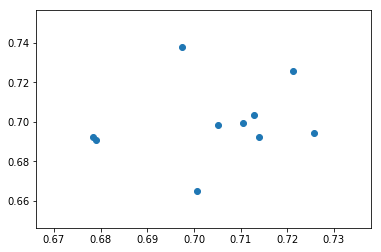

In [22]:
import matplotlib.pyplot as plt
plt.scatter(info_df['local_test_auc'],info_df['test_auc'])

# 输出模块

In [23]:
import time
import numpy as np
from sklearn.metrics import roc_auc_score

date = time.strftime("%Y%m%d-%H%M%S", time.localtime())
res_num = np.argsort([-i for i in info_df['local_test_auc']])

# 选择前n个结果进行平均（手动指定or在本地测试集排序选出）
if False:
    max_auc = -1
    list_temp = []
    for i in range(N):
        list_temp.append(local_test_labels[res_num[i]])
        temp = np.mean(list_temp, axis=0)
        temp_auc = roc_auc_score(Y_local_test, temp)
        print(i, temp_auc)
        if temp_auc > max_auc:
            max_auc = temp_auc
            n = i
else:
    n = 200
    n=min(N,n)

res_num = res_num[0:n]

final_pred_label = np.mean([pred_labels[i] for i in res_num], axis=0)
#local_auc = roc_auc_score(y_test, final_pred_label)
print("本地测试集前", n, "个auc为", [list(info_df['local_test_auc'])[i] for i in res_num], sep="")
#print("平均之后AUC为",local_auc,sep="")

res = pd.DataFrame({
    'cust_id': list(df_test["cust_id"]),
    'label': final_pred_label,
})
res.to_csv("./output/result"+date+".csv", encoding="utf-8", index=False)


本地测试集前200个auc为[0.7257769270633077, 0.7213009244554406, 0.7138409201089955, 0.7128211772179408, 0.7104473495043381, 0.7050644444072953, 0.7006929236530199, 0.6974330898209599, 0.6790024908473896, 0.6784633644828566]


# 一些tips

* 提升n有一定提升(如何确定n？)
  * n=40 0.6763
  * n=10 0.6728
  * n=100 0.6774
  * 太大也不好

# 一些进展

* 随机参数
* XGB模型
* 本地测试集auc较高（0.75+）
* 部分类型变量进行了one-hot处理
* 把细分表除了loan与主表合并

# tbd

* 处理细分表的loan，给出指标
* 确定变量类型，以便对所有（or重要）分类变量进行one-hot处理
* 新模型？

## 10-12
* 0.6824（这次我留了代码\doge）
* 把-99变为-1，本地有提升
* 划出了一个本地测试集
  * 本地测试集（固定）d_localtest
  * 训练集（固定）
    * 评估集（每次的模型不同）dtest
    * 真正的训练集（每次的模型不同）dtrain
* 添加参数nan_num（然并卵）
* tbd
  * 找特征
  * 加x
  * 分析一下参数作用